#### Autor: Jorge Roberto Ponce Martínez
#### Fecha: 7 de Junio de 2025

# Descripcipción del proyecto

Al operador de telecomunicaciones Interconnect le gustaría poder pronosticar su tasa de cancelación de clientes. Si se descubre que un usuario o usuaria planea irse, se le ofrecerán códigos promocionales y opciones de planes especiales. El equipo de marketing de Interconnect ha recopilado algunos de los datos personales de sus clientes, incluyendo información sobre sus planes y contratos.

## Servicios de Interconnect

Interconnect proporciona principalmente dos tipos de servicios:
   1.	Comunicación por teléfono fijo. El teléfono se puede conectar a varias líneas de manera simultánea.
   2.	Internet. La red se puede configurar a través de una línea telefónica (DSL, línea de abonado digital) o a través de un cable de fibra óptica.

Algunos otros servicios que ofrece la empresa incluyen:
   * Seguridad en Internet: software antivirus (ProtecciónDeDispositivo) y un bloqueador de sitios web maliciosos (SeguridadEnLínea).
   * Una línea de soporte técnico (SoporteTécnico).
   * Almacenamiento de archivos en la nube y backup de datos (BackupOnline).
   * Streaming de TV (StreamingTV) y directorio de películas (StreamingPelículas)

La clientela puede elegir entre un pago mensual o firmar un contrato de 1 o 2 años. Puede utilizar varios métodos de pago y recibir una factura electrónica después de una transacción.


# Inicialización

## Librerías

In [1]:
# -----Libraries-----
import os
import pandas as pd
import numpy as np
import math

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, QuantileTransformer

from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

from sklearn.utils import resample

## Variables y Constantes

In [2]:
# -----Constansts
# ----Path file of data sets
c_pathfile=r"Datasets\\"

# ----Random state & Data handle variables
c_random_state = 56106
c_test_size = 0.20

# Funciones

In [3]:
def load_csv_to_dataframe(
    file_path,
    show_info=False, show_describe=False,
    show_head=False, head_rows=5,
    show_sample=False, sample_rows=5,
    parse_date=False, parse_index=0
):
    """
    Loads a CSV file into a pandas DataFrame and optionally displays information, the first few rows,
    or random samples.
    If parse_date flag is True the function will read the csv file with the parameters 'index_col' and
    'parse_dates'. In case the index of the date to parse is not in the first position you can use the
    parameter 'parse_index' to indicate the index in the file to parse.

    Args:
        file_path (str): The path to the CSV file.
        show_info (bool, optional): Flag to display DataFrame information. Defaults to False.
        show_describe (bool, optional): Flag to display DataFrame describe info. Defaults to False.
        show_head (bool, optional): Flag to display the first n_rows of the DataFrame. Defaults to False.
        head_rows (int, optional): Number of rows to show with '.head' of DF
        show_sample (bool, optional): Flag to display random samples of the DataFrame. Defaults to False.
        sample_rows (int, optional): Number of rows to show a sample of DF

    Returns:
        pandas.DataFrame: The DataFrame loaded from the CSV file.
    """

    # ----Try block in case of a runtimeerror reading files
    try:
        # ---Read file and get file name
        if parse_date == True:
            df = pd.read_csv(file_path, index_col=[parse_index], parse_dates=[parse_index])
        else:
            df = pd.read_csv(file_path)

        # --Get file name
        file_name = os.path.basename(file_path)
        
        # ---Show info of the new DataFrame if requested
        if show_info:
            print(f"\n***********DataFrame {file_name}***********")
            print(df.info())

        # ---Show info of the new DataFrame if requested
        if show_describe:
            print(f"\n***********DataFrame Describe {file_name}***********")
            print(df.describe())            
            
        # ---Show first rows of DataFrame if requested
        if show_head:
            print(f"\n***********First {head_rows} registers of DataFrame {file_name}***********")
            print(df.head(head_rows))

        # ---Show sample rows of DataFrame if requested
        if show_sample:
            print(f"\n***********Sampled registers {sample_rows} of DataFrame {file_name}***********")
            print(df.sample(sample_rows))
            
        return df

    # -File not found exception
    except FileNotFoundError:
        print(f"\nError: File not found at {file_path}")
        return None
    # -Any other runtime error
    except Exception as e:
        print(f"\nAn error occurred: {e}")
        return None

In [4]:
def plot_distributions(train, test, valid, title):
    """
    Graficar DataFrames de entrenaimiento, prueba y validación

    Args:
        train (pandas.DataFrame): DataFrame de entrenamiento
        test (pandas.DataFrame): DataFrame de prueba
        valid (pandas.DataFrame): DataFrame de validación
        title (str): Title of the plots
    """
    
    # ----Subplots for comparison
    fig, axes = plt.subplots(1, 3, figsize=(21, 5))

    # ---Plot DF Entrenamiento
    sns.histplot(train, bins=30, kde=True, ax=axes[0])
    axes[0].set_title(f'{title}')

    # ---Plot DF Prueba
    sns.histplot(test, bins=30, kde=True, ax=axes[1])
    axes[1].set_title(f'{title}')

    # ---Plot DF Validación
    sns.histplot(valid, bins=30, kde=True, ax=axes[2])
    axes[2].set_title(f'{title}')    

    plt.show()

In [5]:
def find_best_rf_params(X_train, y_train, n_estimators_list, max_depth_list):
    """
    Encuentra los mejores hiperparámetros para un RandomForestClassifier
    usando GridSearchCV con rangos de búsqueda personalizables.

    Args:
        X_train: DataFrame de características de entrenamiento.
        y_train: Serie de la variable objetivo de entrenamiento.
        n_estimators_list: Una lista de valores para probar en n_estimators.
        max_depth_list: Una lista de valores para probar en max_depth.

    Returns:
        El mejor modelo de RandomForestClassifier encontrado.
    """
    print("Iniciando la búsqueda de hiperparámetros para RandomForestClassifier...")

    # 1. Definir la parrilla de parámetros usando los argumentos de la función
    param_grid = {
        'n_estimators': n_estimators_list,
        'max_depth': max_depth_list
    }

    # 2. Crear el modelo base
    rf_model = RandomForestClassifier(
        random_state=c_random_state,
        class_weight='balanced'
    )

    # 3. Configurar GridSearchCV
    grid_search = GridSearchCV(
        estimator=rf_model,
        param_grid=param_grid,
        scoring='roc_auc',
        cv=5,
        n_jobs=-1,
        verbose=1
    )

    # 4. Iniciar la búsqueda
    grid_search.fit(X_train, y_train)

    # 5. Mostrar los mejores resultados
    print("\nBúsqueda completada.")
    print(f"Mejores hiperparámetros encontrados: {grid_search.best_params_}")
    print(f"Mejor puntuación AUC-ROC (en validación cruzada): {grid_search.best_score_:.4f}")

    return grid_search.best_estimator_, grid_search.best_params_

In [6]:
def find_best_lgbm_params(X_train, y_train, param_grid):
    """
    Encuentra los mejores hiperparámetros para un LGBMClassifier
    usando GridSearchCV.

    Args:
        X_train: DataFrame de características de entrenamiento.
        y_train: Serie de la variable objetivo de entrenamiento.
        param_grid: Un diccionario con los hiperparámetros a probar.

    Returns:
        El mejor modelo LGBMClassifier encontrado.
    """
    print("Iniciando la búsqueda de hiperparámetros para LGBMClassifier...")

    # 1. Crear el modelo base
    lgbm_model = lgb.LGBMClassifier(random_state=c_random_state)

    # 2. Configurar GridSearchCV
    grid_search = GridSearchCV(
        estimator=lgbm_model,
        param_grid=param_grid,
        scoring='roc_auc',
        cv=5,
        n_jobs=-1,
        verbose=1
    )

    # 3. Iniciar la búsqueda en los datos de entrenamiento
    # Usaremos los datos sobremuestreados que han dado buenos resultados
    grid_search.fit(X_train, y_train)

    # 4. Mostrar los mejores resultados
    print("\nBúsqueda completada.")
    print(f"Mejores hiperparámetros encontrados: {grid_search.best_params_}")
    print(f"Mejor puntuación AUC-ROC (en validación cruzada): {grid_search.best_score_:.4f}")

    return grid_search.best_estimator_, grid_search.best_params_

In [7]:
def evaluate_model(model, X_data, y_data, model_name="Modelo"):
    """
    Calcula y muestra las métricas de Accuracy y AUC-ROC para un modelo dado.

    Args:
        model: El modelo de machine learning ya entrenado.
        X_data: El conjunto de datos de características para la evaluación (ej. X_val).
        y_data: El conjunto de datos del objetivo para la evaluación (ej. y_val).
        model_name (str): El nombre del modelo para mostrar en la salida.
    """
    # 1. Hacer predicciones
    y_pred = model.predict(X_data)
    y_proba = model.predict_proba(X_data)[:, 1] # Probabilidades para la clase positiva

    # 2. Calcular las métricas
    accuracy = accuracy_score(y_data, y_pred)
    auc_roc = roc_auc_score(y_data, y_proba)

    # 3. Mostrar los resultados
    print(f"--- {model_name} ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUC-ROC:  {auc_roc:.4f}")
    print("-" * (len(model_name) + 8)) # Línea separadora dinámica

# EDA (Análisis Exploratorio de los Datos)

## Cargar Datos (Visión General)

In [8]:
# -----Carga de los datasets
df_contract = load_csv_to_dataframe(
    (c_pathfile + "contract.csv"),
    show_info=True,show_describe=True,
    show_head=True, head_rows=5,
    show_sample=True, sample_rows=5
)


***********DataFrame contract.csv***********
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None

***********DataFrame Describe contract.csv***********
       MonthlyCharges
count     7043.000000
mean        64.761692
std         30.090047
min         18.250000
25%         35.500000
50%         70.350000
75%         89.850000
max        118.750000

***********First 5 registers of DataFrame contract.csv***********

In [9]:
print(df_contract["BeginDate"].describe())
print()
print(df_contract["BeginDate"].min())

count           7043
unique            77
top       2014-02-01
freq             366
Name: BeginDate, dtype: object

2013-10-01


In [10]:
print(df_contract["EndDate"].describe())
print()
print(df_contract["EndDate"].min())

count     7043
unique       5
top         No
freq      5174
Name: EndDate, dtype: object

2019-10-01 00:00:00


In [11]:
df_personal = load_csv_to_dataframe(
    (c_pathfile + "personal.csv"),
    show_info=True,show_describe=True,
    show_head=True, head_rows=5,
    show_sample=True, sample_rows=5
)


***********DataFrame personal.csv***********
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None

***********DataFrame Describe personal.csv***********
       SeniorCitizen
count    7043.000000
mean        0.162147
std         0.368612
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000

***********First 5 registers of DataFrame personal.csv***********
   customerID  gender  SeniorCitizen Partner Dependents
0  7590-VHVEG  Female              0     Yes         No
1  5575-GNVDE    Male              0      No         No
2  3668-QPY

In [12]:
df_internet = load_csv_to_dataframe(
    (c_pathfile + "internet.csv"),
    show_info=True,show_describe=True,
    show_head=True, head_rows=5,
    show_sample=True, sample_rows=5
)


***********DataFrame internet.csv***********
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None

***********DataFrame Describe internet.csv***********
        customerID InternetService OnlineSecurity OnlineBackup  \
count         5517            5517           5517         5517   
unique        5517               2              2            2   
top     7590-VHVEG     Fiber optic             No           No   
freq             1    

In [13]:
df_phone = load_csv_to_dataframe(
    (c_pathfile + "phone.csv"),
    show_info=True,show_describe=True,
    show_head=True, head_rows=5,
    show_sample=True, sample_rows=5
)


***********DataFrame phone.csv***********
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None

***********DataFrame Describe phone.csv***********
        customerID MultipleLines
count         6361          6361
unique        6361             2
top     5575-GNVDE            No
freq             1          3390

***********First 5 registers of DataFrame phone.csv***********
   customerID MultipleLines
0  5575-GNVDE            No
1  3668-QPYBK            No
2  9237-HQITU            No
3  9305-CDSKC           Yes
4  1452-KIOVK           Yes

***********Sampled registers 5 of DataFrame phone.csv***********
      customerID MultipleLines
185   7674-YTAFD            No
2931  5519-NPHVG           Yes
676   3966-HRMZA         

## Revisión Balanceo de Clases

Nuestra columna objetivo es 'EndDate' para saber si un cliente ya canceló su servicio con 'Interconnect'.
   * Si el valor de la columna es 'No', significa que no ha cancelado.
   * Si el valor de la columan es una fecha, significa que ya canceló.

In [14]:
df_contract["EndDate"].value_counts()

EndDate
No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: count, dtype: int64

   * Nuestro set de datos está desbalanceado:
      - El número de datos sin cacelaciones es: 5174
      - El número de datos de clientes que cancelaron es: 1869
      - Balance de la clase: 73.46%~ - 26.53%~

## Conclusiones sección 'Cargar Datos (Visión General)'

   1. Set de datos: 'contract.csv':
      * No hay datos nulos.
      * No se observan datos atípicos con el atributo describe.
      * Al imprimir una muestra de los datos se observar la necesidad de tratar la columna 'BeginDate' para pasarlo a tipo de dato fecha.
      * Al imprimir una muestra de los datos se observar la necesidad de tratar la columna 'EndDate' para pasarlo a tipo de dato fecha y quitarle la extensión de hora si todos los registros no aportan información adicional a '00:00:00'.
      * En la siguiente sección 'Preparación de Datos' se analizará y cambiara en caso de ser necesario el tipo de datos de cada columna junto con la codificación de cada columna y escalamiento en caso de ser necesario.


   2. Set de datos: 'personal.csv':
      * No hay datos nulos.
      * No se observan datos atípicos con el atributo describe.
      * En la siguiente sección 'Preparación de Datos' se analizará y cambiara en caso de ser necesario el tipo de datos de cada columna junto con la codificación de cada columna y escalamiento en caso de ser necesario.   


   3. Set de datos: 'internet.csv':
      * No hay datos nulos.
      * No se observan datos atípicos con el atributo describe. Todas las columnas booleanas o de solo 2 opciones en efecto tienen solo 2 valores únicos.
      * Hay menos registros que los datasets anteriores (contract, personal).
         - Esto puede ser que sean clientes que ya cancelaron o no tienen ese servicio contratado y por lo tanto no se tienen sus datos.
	     - En la siguiente sección al juntar los DataFrames obtenidos en uno solo se analizará más a fondo esta observación.
      * En la siguiente sección 'Preparación de Datos' se analizará y cambiara en caso de ser necesario el tipo de datos de cada columna junto con la codificación de cada columna y escalamiento en caso de ser necesario.


   4. Set de datos: 'phone.csv':
      * No hay datos nulos.
      * No se observan datos atípicos con el atributo describe. La columna booleanatienen solo 2 valores únicos.
      * Hay menos registros que los datasets anteriores (contract, personal).
         - Esto puede ser que sean clientes que ya cancelaron o no tienen ese servicio contratado y por lo tanto no se tienen sus datos.
	     - En la siguiente sección al juntar los DataFrames obtenidos en uno solo se analizará más a fondo esta observación.
      * En la siguiente sección 'Preparación de Datos' se analizará y cambiara en caso de ser necesario el tipo de datos de cada columna junto con la codificación de cada columna y escalamiento en caso de ser necesario.  

   5. Existe un desbalance en nuestro set de datos en nuestra columan objetivo:
      * Balance de la clase: 73.46%~ - 26.53%~ (No Cancelaron - Ya Cancelaron)


## Preguntas sección 'Cargar Datos (Visión General)'

   1. Set de datos: 'contract.csv'
      * ¿Cuál es la diferencia entre las columnas 'MonthlyCharges'  y 'TotalCharges'
   2. Set de datos: 'personal.csv'
      * ¿Que representan las columnas 'Partner' 'Dependents'?
   3. Set de datos 'internet.csv'
   4. Set de datos 'phone.csv' 

# Plan de Trabajo

## Preguntas a Lider de Equipo

   1. Juego de datos: 'contract.csv':
      * ¿Cuál es la diferencia o relación entre las columnas 'MonthlyCharges'  y 'TotalCharges'
   2. Juego de datos: 'personal.csv':
      * ¿Que representan las columnas 'Partner' 'Dependents'?
   3. Juego de datos: 'internet.csv' y 'phone.csv':
      * ¿Es correcto asumir que la información de estos 2 juegos de datos corresponden a los mismos usuarios del juego de datos 'contract.csv'?
      * Los clientes que no aparecen en los set de datos significa que no tienen contratado ese servicio (internet o teléfono), ¿Es correcto?.
   4. Columnas 'BeginDate' y 'EndDate' en el juego de datos 'contract.csv':
      * ¿Cuál es la fecha de extracción de los datos?. Para ver si es posible calcular la antigüedad de un cliente como característica que aporte al modelo.
         - En la descripción del proyecto se menciona la fecha del 1 de febrero del 2020. La pregunta es para confirmar y saber el rango de nuestro juego de datos.
      * Solo hay cuatro fechas en la columna 'EndDate'. Esto hace pensar que las cancelaciones empezaron a aumentar entre Octubre 2019 y Enero 2020. ¿Esta es la causa principal del requerimiento?, ¿Es posible tener información sobre fallas en el sistema o reportes de usuario sobre el servicio, posible aumento de precios o algún factor externo que haya influenciado la salida de estos clientes?
         * 2019-11-01 00:00:00     485
         * 2019-12-01 00:00:00     466
         * 2020-01-01 00:00:00     460
         * 2019-10-01 00:00:00     458


## Plan

   1. En la preparación de datos se unificará la información en un solo DataFrame:
      * En el DataFrame unificado se cambiaran los tipos de datos de las columnas. Por ejemplo cambiar el tipo de dato de las columnas 'BeginDate' a fecha nos permitirá hacer más operaciones y de manera correcta sobre fechas.
      * Se rellenaran los datos de los clientes que solo cuentan con un plan teléfono o internet al unificar la información en un solo DataFrame.
      * Se aplicará codificación a los datos. Para ayudar a los algoritmos utilizados en los modelos.
      * Se aplicará escalamiento en los datos como 'MonthlyCharges' y 'TotalCharges' para que el modelo no los considere como las características con más relevancia.

   2. Esto es una tarea de clasificación (Ya canceló, no ha cancelado):
      * Se crearán los modelos 'LogisticRegression' y 'RandomForestClassifier'
         - De los algoritmos que lo permitan se buscarán los mejores hyperparámetros.
     
   3. Acerca del balanceo de las clases: 73.46%~ - 26.53%~ (No Cancelaron - Ya Cancelaron)
      * Primero se generarán los modelos y se evaluará con las métricas 'exactitud' y 'AUC-ROC' y tener una referencia
         - NOTA: La métrica 'AUC-ROC' es la ideal para este proyecto por  medir la capacidad del modelo para distinguir entre clases. Un valor de 0.5 es aleatorio y 1.0 es perfecto. Es una excelente elección.
      * Luego se probará con los mismos modelos adicionado el parámetro 'class_weight'.
         - Este parámetro asigna un "peso" o "costo" mayor a los errores de clasificación en la clase minoritaria. De esta manera, el modelo es penalizado más fuertemente si se equivoca al predecir una cancelación de cliente.
      * Al final se realizará un remuestreo para balancear las clases del juego de datos.
      * Se compararán las métricas para evaluar si hay mejora con cada método y paso.


# Preparación de Datos

## Unión de DataFrames

In [15]:
# ----- Unificar los DataFrames -----
# ----1. Empezamos con el DataFrame 'df_contract' como base.
# ----2. Unimos 'df_personal'. Como todos los clientes en 'df_contract'
#    tienen datos personales, usamos un 'inner' join.
df_clients = pd.merge(
    df_contract,
    df_personal,
    on='customerID',
    how='inner'
)

In [16]:
# ----3. Unimos 'df_internet'. Un cliente puede no tener servicio de internet,
#    por lo que usamos un 'left' join para no perder clientes.
df_clients = pd.merge(
    df_clients,
    df_internet,
    on='customerID',
    how='left'
)

In [17]:
# ----4. Unimos 'df_phone'. De igual forma, usamos 'left' join por si
#    un cliente no tiene servicio telefónico.
df_clients = pd.merge(
    df_clients,
    df_phone,
    on='customerID',
    how='left'
)

In [18]:
# ---- Verificación del resultado
print("DataFrame unificado 'df_clients':")
print(df_clients.head())
print("\nForma del DataFrame final:", df_clients.shape)
print("\nInformación del DataFrame final:")
df_clients.info()

DataFrame unificado 'df_clients':
   customerID   BeginDate              EndDate            Type  \
0  7590-VHVEG  2020-01-01                   No  Month-to-month   
1  5575-GNVDE  2017-04-01                   No        One year   
2  3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month   
3  7795-CFOCW  2016-05-01                   No        One year   
4  9237-HQITU  2019-09-01  2019-11-01 00:00:00  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  \
0              Yes           Electronic check           29.85        29.85   
1               No               Mailed check           56.95       1889.5   
2              Yes               Mailed check           53.85       108.15   
3               No  Bank transfer (automatic)           42.30      1840.75   
4              Yes           Electronic check           70.70       151.65   

   gender  SeniorCitizen Partner Dependents InternetService OnlineSecurity  \
0  Female             

## Tipo de Columnas

### Fechas

In [19]:
# ----- Tratamiento de Fechas
# ---- 1. Convertir la columna 'BeginDate' a datetime ---
# Se asume que el formato es Año-Mes-Día
df_clients['BeginDate'] = pd.to_datetime(df_clients['BeginDate'], format='%Y-%m-%d')

In [20]:
# ---- 2. Convertir la columna 'EndDate' a datetime ---
# Usando 'errors='coerce'' es la forma más directa.
# Reemplazará automáticamente 'No' y cualquier otro valor no válido por NaT (Not a Time).
df_clients['EndDate'] = pd.to_datetime(df_clients['EndDate'], errors='coerce')

C:\Users\jorge\AppData\Local\Temp\ipykernel_6820\231808699.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_clients['EndDate'] = pd.to_datetime(df_clients['EndDate'], errors='coerce')


In [21]:
# ---- Verificación de los cambios ---
print("Información del DataFrame después de la conversión de fechas:")
df_clients.info()

print("\nEjemplos de las columnas con los nuevos tipos de datos:")
print(df_clients[['BeginDate', 'EndDate']].head())

# Puedes verificar cuántos valores 'NaT' (clientes activos) hay en 'EndDate'
print(f"\nNúmero de clientes activos (valores NaT en EndDate): {df_clients['EndDate'].isnull().sum()}")

Información del DataFrame después de la conversión de fechas:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   5517 non-null   object        
 13  OnlineSecurity  

### Valores Numéricos

In [22]:
# ----- Tratamiento de valores numéricos
# ---- 1. Convertir 'TotalCharges' a un tipo numérico ---
# 'errors='coerce'' transformará cualquier valor no numérico (como ' ') en NaN.
df_clients['TotalCharges'] = pd.to_numeric(df_clients['TotalCharges'], errors='coerce')

In [23]:
# ---- 2. Manejar los valores nulos (NaN) resultantes ---
# Un valor nulo aquí probablemente significa que el cliente es nuevo y aún no tiene
# cargos totales. La opción más lógica es rellenar esos nulos con 0.
df_clients['TotalCharges'].fillna(0, inplace=True)

C:\Users\jorge\AppData\Local\Temp\ipykernel_6820\2434402550.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clients['TotalCharges'].fillna(0, inplace=True)


In [24]:
# ---- Verificación del resultado ---
print("Se ha cambiado el tipo de dato de 'TotalCharges' a numérico.\n")
print("Valores nulos en 'TotalCharges' después del tratamiento:")
print(df_clients['TotalCharges'].isnull().sum())

print("\nInformación actualizada del DataFrame:")
df_clients.info()

Se ha cambiado el tipo de dato de 'TotalCharges' a numérico.

Valores nulos en 'TotalCharges' después del tratamiento:
0

Información actualizada del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 no

## Columna objetivo(Target)

In [25]:
# ----- Crear columna objetivo
# ---- 1. Crear la columna 'TargetCancel' ---
# Usamos np.where para una asignación condicional eficiente.
# Si 'EndDate' es nulo (isnull() es True), el cliente está activo -> asignamos 0.
# Si 'EndDate' no es nulo (tiene una fecha), el cliente canceló -> asignamos 1.
df_clients['TargetCancel'] = np.where(df_clients['EndDate'].isnull(), 0, 1)

In [26]:
# --- Verificación del resultado ---
print("Se ha creado la columna 'TargetCancel'.\n")

# Mostramos la distribución de la nueva variable objetivo.
# Esto nos confirma el desbalance de clases que detectaste inicialmente.
print("Distribución de la variable objetivo (0 = No canceló, 1 = Sí canceló):")
print(df_clients['TargetCancel'].value_counts())

print("\nInformación actualizada del DataFrame:")
df_clients.info()

Se ha creado la columna 'TargetCancel'.

Distribución de la variable objetivo (0 = No canceló, 1 = Sí canceló):
TargetCancel
0    5174
1    1869
Name: count, dtype: int64

Información actualizada del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-nu

## Nueva Columna 'Tenure' (Antigüedad del Cliente)

In [27]:
# ----- Nueva Columna 'Tenure'
# ---- 1. Definir la fecha de extracción de los datos ---
# Esta fecha se usará para los clientes que siguen activos (EndDate es NaT)
extraction_date = pd.to_datetime('2020-02-01')

In [28]:
# ---- 2. Rellenar los valores nulos de 'EndDate' ---
# Creamos una serie temporal donde los NaT se reemplazan con la fecha de extracción
effective_end_date = df_clients['EndDate'].fillna(extraction_date)

In [29]:
# ---- 3. Calcular la diferencia en meses ---
# El método más robusto es convertir las fechas a períodos mensuales ('M')
# y luego restar. El atributo '.n' nos da el número entero de meses.
tenure_months = (effective_end_date.dt.to_period('M') - df_clients['BeginDate'].dt.to_period('M'))
df_clients['Tenure'] = tenure_months.apply(lambda x: x.n)

In [30]:
# ---- Caso especial: Clientes nuevos ---
# Si un cliente se inscribe y se va en el mismo mes, la diferencia puede ser 0.
# A menudo, en negocio, se cuenta como 1 mes de antigüedad.
# Si la antigüedad es 0, la cambiaremos a 1.
df_clients.loc[df_clients['Tenure'] == 0, 'Tenure'] = 1

In [31]:
# ---- Verificación del resultado ---
print("Se ha creado la columna 'Tenure'.\n")
print("Estadísticas descriptivas de la antigüedad (en meses):")
print(df_clients['Tenure'].describe())

print("\nEjemplo de las columnas para verificar el cálculo:")
print(df_clients[['BeginDate', 'EndDate', 'Tenure']].head())

# Verificamos un cliente activo para confirmar que se usó la fecha de extracción
print("\nEjemplo de un cliente activo (EndDate es NaT):")
print(df_clients[df_clients['EndDate'].isnull()][['BeginDate', 'EndDate', 'Tenure']].head())

Se ha creado la columna 'Tenure'.

Estadísticas descriptivas de la antigüedad (en meses):
count    7043.000000
mean       32.372710
std        24.557454
min         1.000000
25%         9.000000
50%        29.000000
75%        55.000000
max        72.000000
Name: Tenure, dtype: float64

Ejemplo de las columnas para verificar el cálculo:
   BeginDate    EndDate  Tenure
0 2020-01-01        NaT       1
1 2017-04-01        NaT      34
2 2019-10-01 2019-12-01       2
3 2016-05-01        NaT      45
4 2019-09-01 2019-11-01       2

Ejemplo de un cliente activo (EndDate es NaT):
   BeginDate EndDate  Tenure
0 2020-01-01     NaT       1
1 2017-04-01     NaT      34
3 2016-05-01     NaT      45
6 2018-04-01     NaT      22
7 2019-04-01     NaT      10


### Columna 'EndDate', eliminar

In [32]:
# -----Eliminar columna que ya no agrega valor al modelo
# ---- 1. Eliminar la columna 'EndDate' ---
# Ya no la necesitamos porque su información está capturada en 'Tenure' y 'TargetCancel'.
df_clients.drop(columns=['EndDate'], inplace=True)

In [33]:
# ---- Verificación del resultado ---
print("Se ha eliminado 'EndDate'.\n")

print("\nInformación actualizada del DataFrame:")
df_clients.info()

Se ha eliminado 'EndDate'.


Información actualizada del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
 7   gender            7043 non-null   object        
 8   SeniorCitizen     7043 non-null   int64         
 9   Partner           7043 non-null   object        
 10  Dependents        7043 non-null   object        
 11  InternetService   5517 non-null   object        
 12  OnlineSecurity    5517 non-null   object        
 13  OnlineBack

## Revisión de Valores Únicos

In [34]:
print(df_clients["MultipleLines"].describe())
print()
print(df_clients["MultipleLines"].unique())

count     6361
unique       2
top         No
freq      3390
Name: MultipleLines, dtype: object

[nan 'No' 'Yes']


***Resumen de valores en columnas:***

	-Type: Contiene 3 valores:
		['Month-to-month' 'One year' 'Two year']
	-PaperlessBilling: Contiene 2 valores:
		['Yes' 'No']
	-PaymentMethod: Contiene 4 valores:
		['Electronic check' 'Mailed check' 'Bank transfer (automatic)' 'Credit card (automatic)']
	-gender: Contiene 2 valores:
		['Female' 'Male']
	-SeniorCitizen: Contiene 2 valores:
		[0 1]
	-Partner: Contiene 2 valores:
		['Yes' 'No']
	-Dependents: Contiene 2 valores:
		['No' 'Yes']
	-InternetService:
		['DSL' 'Fiber optic' nan]
	-OnlineSecurity:
		['No' 'Yes' nan]
	-OnlineBackup:
		['Yes' 'No' nan]
	-DeviceProtection:
		['No' 'Yes' nan]
	-TechSupport:
		['No' 'Yes' nan]
	-StreamingTV:
		['No' 'Yes' nan]
	-StreamingMovies:
		['No' 'Yes' nan]
	-MultipleLines:
		[nan 'No' 'Yes']

## Tratar Valores Nulos

In [35]:
# -----Tratar valores nulos
# ---- 1. Definir la lista de columnas a modificar ---
# Estas son todas las columnas donde 'nan' debe ser reemplazado por 'No'.
columns_to_fill = [
    'InternetService',
    'OnlineSecurity',
    'OnlineBackup',
    'DeviceProtection',
    'TechSupport',
    'StreamingTV',
    'StreamingMovies',
    'MultipleLines'
]

In [36]:
# ---- 2. Reemplazar los valores nulos (NaN) con 'No' ---
# Usamos el método .fillna() en las columnas seleccionadas.
df_clients[columns_to_fill] = df_clients[columns_to_fill].fillna('No')

In [37]:
# ---- Verificación del resultado ---
print("Se han reemplazado los valores nulos con 'No'.\n")

# --- Iteramos sobre la lista de columnas para verificar que ya no hay nulos.
for col in columns_to_fill:
    print(f"Valores únicos en la columna '{col}':")
    print(df_clients[col].unique())
    print("-" * 30)

# --- También puedes usar .info() para una vista general y confirmar que no hay nulos.
print("\nInformación actualizada del DataFrame:")
df_clients.info()

Se han reemplazado los valores nulos con 'No'.

Valores únicos en la columna 'InternetService':
['DSL' 'Fiber optic' 'No']
------------------------------
Valores únicos en la columna 'OnlineSecurity':
['No' 'Yes']
------------------------------
Valores únicos en la columna 'OnlineBackup':
['Yes' 'No']
------------------------------
Valores únicos en la columna 'DeviceProtection':
['No' 'Yes']
------------------------------
Valores únicos en la columna 'TechSupport':
['No' 'Yes']
------------------------------
Valores únicos en la columna 'StreamingTV':
['No' 'Yes']
------------------------------
Valores únicos en la columna 'StreamingMovies':
['No' 'Yes']
------------------------------
Valores únicos en la columna 'MultipleLines':
['No' 'Yes']
------------------------------

Información actualizada del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------   

## Codificación de Columnas

### Ordinal Encoding

In [38]:
# ----- Ordinal Encoding para columnas con un orden de importancia
# ---- 1. Ordinal Encoding para la columna 'Type' ---
# Se define un mapa explícito para asegurar el orden correcto.
# Month-to-month (0) < One year (1) < Two year (2)
type_mapping = {'Month-to-month': 0, 'One year': 1, 'Two year': 2}
df_clients['Type'] = df_clients['Type'].map(type_mapping)

### OHE (One-Hot Encoding)

In [39]:
# ----- OHE para columnas sin un orden de importancia definido (Solo presencia)
# ---- 1. Codificación Binaria para columnas con dos categorías ---
# Se identifican todas las columnas que se pueden representar con 0 y 1.
# Para 'gender', se asgina 1 a 'Male' y 0 a 'Female' como convención.
binary_cols = [
    'PaperlessBilling', 'Partner', 'Dependents', 'OnlineSecurity',
    'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
    'StreamingMovies', 'MultipleLines'
]

In [40]:
# ---Se aplica el mapeo 'Yes' -> 1, 'No' -> 0
for col in binary_cols:
    df_clients[col] = df_clients[col].map({'Yes': 1, 'No': 0})

In [41]:
# ---Se codifica 'gender' de la misma forma
df_clients['gender'] = df_clients['gender'].map({'Male': 1, 'Female': 0})

In [42]:
# ---- 2. One-Hot Encoding para las columnas restantes ---
# Se aplica a 'PaymentMethod' e 'InternetService' que tienen más de 2 categorías sin orden.
# 'drop_first=True' elimina la primera categoría para evitar multicolinealidad,
# lo cual es una buena práctica para modelos de regresión.
# 'dtype=int' asegura que las nuevas columnas sean 0 y 1.
df_clients = pd.get_dummies(
    df_clients,
    columns=['PaymentMethod', 'InternetService'],
    drop_first=True,
    #drop_first=False,
    dtype=int
)

In [43]:
# --- Verificación Final ---
print("Se ha realizado la codificación de variables categóricas.")
print("Todas las columnas son ahora numéricas.\n")

print("Primeras filas del DataFrame codificado:")
print(df_clients.head())

print("\nInformación actualizada del DataFrame:")
df_clients.info()

Se ha realizado la codificación de variables categóricas.
Todas las columnas son ahora numéricas.

Primeras filas del DataFrame codificado:
   customerID  BeginDate  Type  PaperlessBilling  MonthlyCharges  \
0  7590-VHVEG 2020-01-01     0                 1           29.85   
1  5575-GNVDE 2017-04-01     1                 0           56.95   
2  3668-QPYBK 2019-10-01     0                 1           53.85   
3  7795-CFOCW 2016-05-01     1                 0           42.30   
4  9237-HQITU 2019-09-01     0                 1           70.70   

   TotalCharges  gender  SeniorCitizen  Partner  Dependents  ...  StreamingTV  \
0         29.85       0              0        1           0  ...            0   
1       1889.50       1              0        0           0  ...            0   
2        108.15       1              0        0           0  ...            0   
3       1840.75       1              0        0           0  ...            0   
4        151.65       0              0        

## Limpieza de Columnas

In [44]:
# ----- Eliminar las columnas redundantes o no necesarias para el escalamiento y modelo
# ---- Eliminar las columnas 'BeginDate' y 'customerID' ---
# No aportan valor predictivo o su información ya fue capturada.
df_clients.drop(columns=['BeginDate', 'customerID'], inplace=True)


In [45]:
# ---- Verificación ---
print("Se han eliminado las columnas 'BeginDate' y 'customerID'.")
print("El DataFrame está listo para el escalamiento.\n")

# Mostramos la información para confirmar que las columnas ya no están.
df_clients.info()

Se han eliminado las columnas 'BeginDate' y 'customerID'.
El DataFrame está listo para el escalamiento.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Type                                   7043 non-null   int64  
 1   PaperlessBilling                       7043 non-null   int64  
 2   MonthlyCharges                         7043 non-null   float64
 3   TotalCharges                           7043 non-null   float64
 4   gender                                 7043 non-null   int64  
 5   SeniorCitizen                          7043 non-null   int64  
 6   Partner                                7043 non-null   int64  
 7   Dependents                             7043 non-null   int64  
 8   OnlineSecurity                         7043 non-null   int64  
 9   OnlineBackup                       

## Escalamiento de los Datos

### División de los Datos

In [46]:
# ----- Separación de datos en entrenamiento, validación y prueba
# ---- 1. Separar las características (X) y la variable objetivo (y) ---
# ---X contiene todas las columnas EXCEPTO la que queremos predecir ('TargetCancel')
X = df_clients.drop(columns='TargetCancel')

# ---y contiene ÚNICAMENTE la columna que queremos predecir
y = df_clients['TargetCancel']

In [47]:
# ---- 2. Primera división: Separar el conjunto de prueba (20%) ---
# Primero, apartamos un 20% de los datos que será nuestro conjunto de prueba final.
# El 80% restante lo usaremos para crear los conjuntos de entrenamiento y validación.
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.2,       # 20% para el conjunto de prueba
    random_state=c_random_state,
    stratify=y
)

In [48]:
# ---- 3. Segunda división: Crear entrenamiento (60%) y validación (20%) ---
# Ahora dividimos el 80% temporal. Queremos un 25% de este para validación,
# ya que 0.25 * 0.80 = 0.20 (20% del total original).
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.25,      # 25% del 80% restante para validación
    random_state=c_random_state,
    stratify=y_temp
)

In [49]:
# ---- 4. Escalar las características numéricas ---
numeric_cols = ['Tenure', 'MonthlyCharges', 'TotalCharges']
scaler = QuantileTransformer(output_distribution="normal", random_state=c_random_state)

In [50]:
# ---Copiamos los dataframes para evitar el SettingWithCopyWarning
X_train = X_train.copy()
X_val = X_val.copy()
X_test = X_test.copy()

In [51]:
# ---AJUSTAMOS el escalador SÓLO con los datos de ENTRENAMIENTO
scaler.fit(X_train[numeric_cols])

QuantileTransformer(output_distribution='normal', random_state=56106)


🔹 Tenure: DataFrame Originales


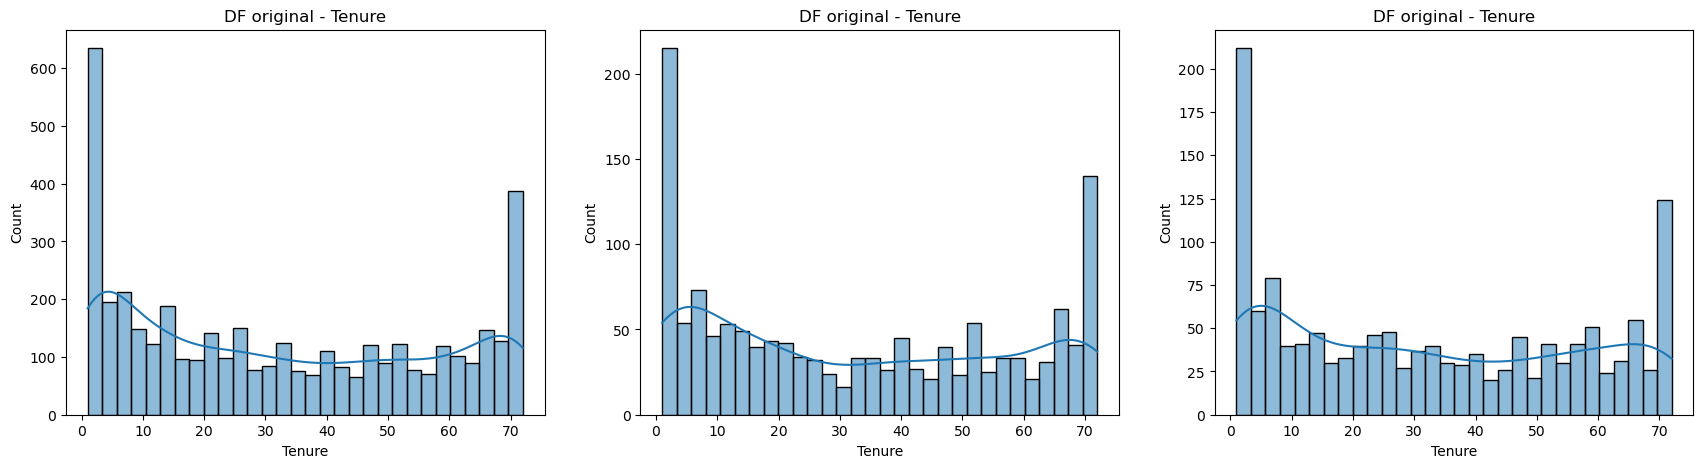


🔹 MonthlyCharges: DataFrame Originales


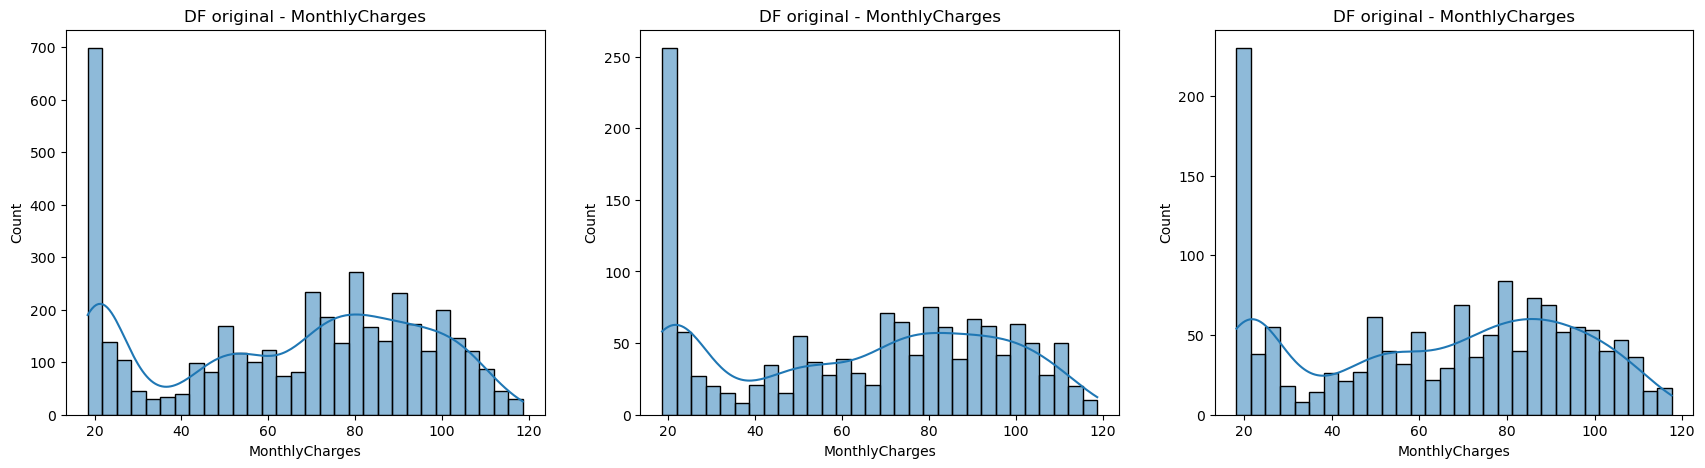


🔹 TotalCharges: DataFrame Originales


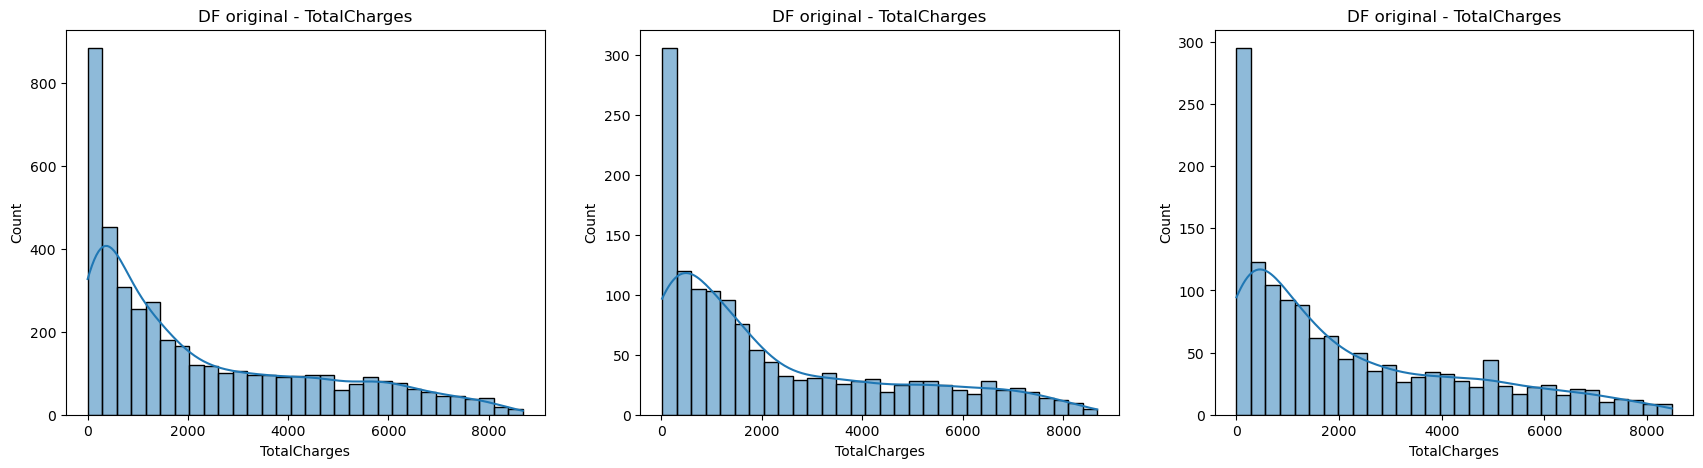

In [52]:
# ---Graficamos antes de la transformación
# 🔹 Graficamos cada DF
for col in numeric_cols:
    print(f"\n🔹 {col}: DataFrame Originales")
    plot_distributions(
        X_train[col], X_val[col], X_test[col], f'DF original - {col}'
    )

In [53]:
# ---TRANSFORMAMOS los tres conjuntos de datos con el escalador ya ajustado
X_train[numeric_cols] = scaler.transform(X_train[numeric_cols])
X_val[numeric_cols] = scaler.transform(X_val[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])


🔹 Tenure: DataFrame Transformados


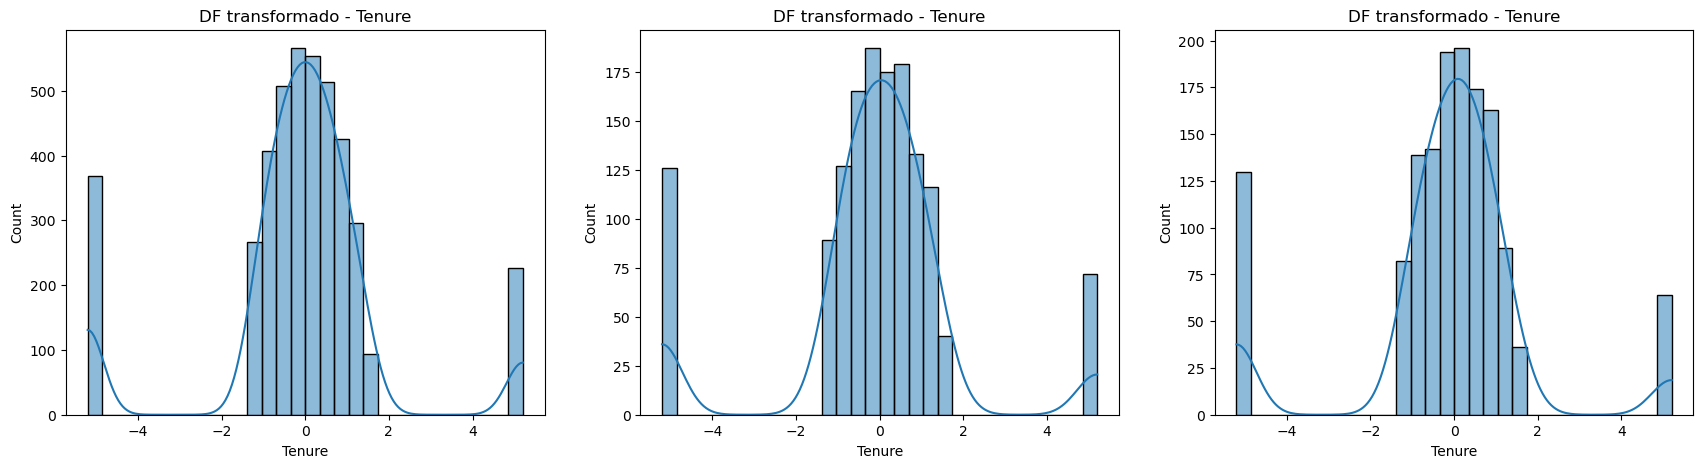


🔹 MonthlyCharges: DataFrame Transformados


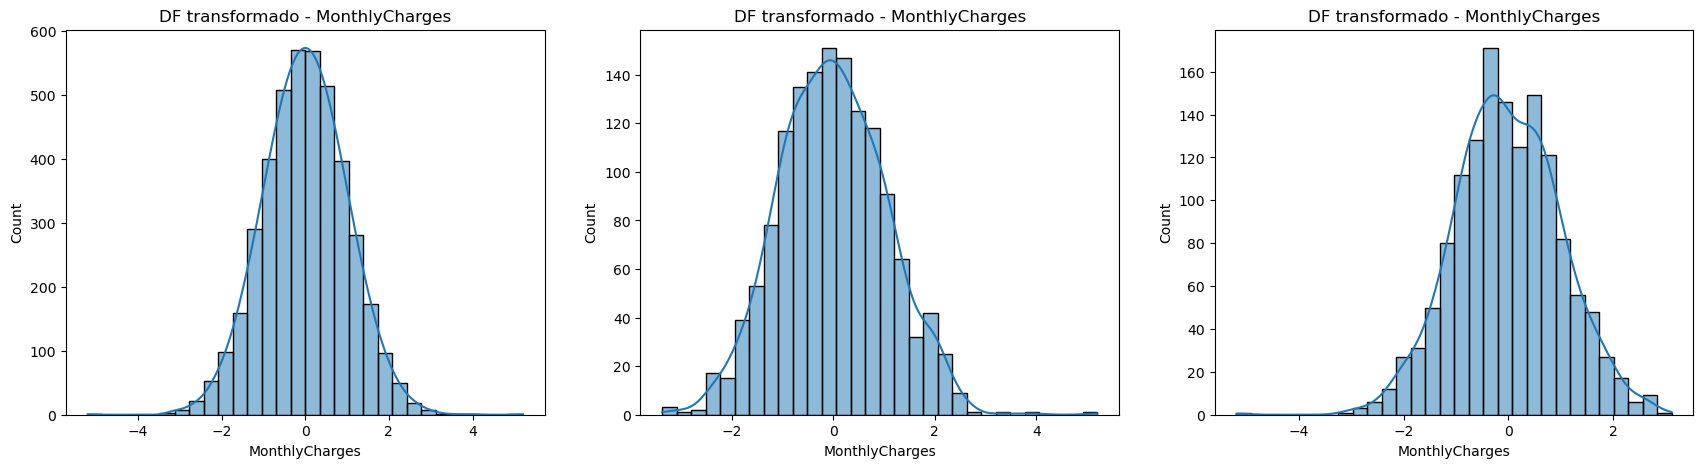


🔹 TotalCharges: DataFrame Transformados


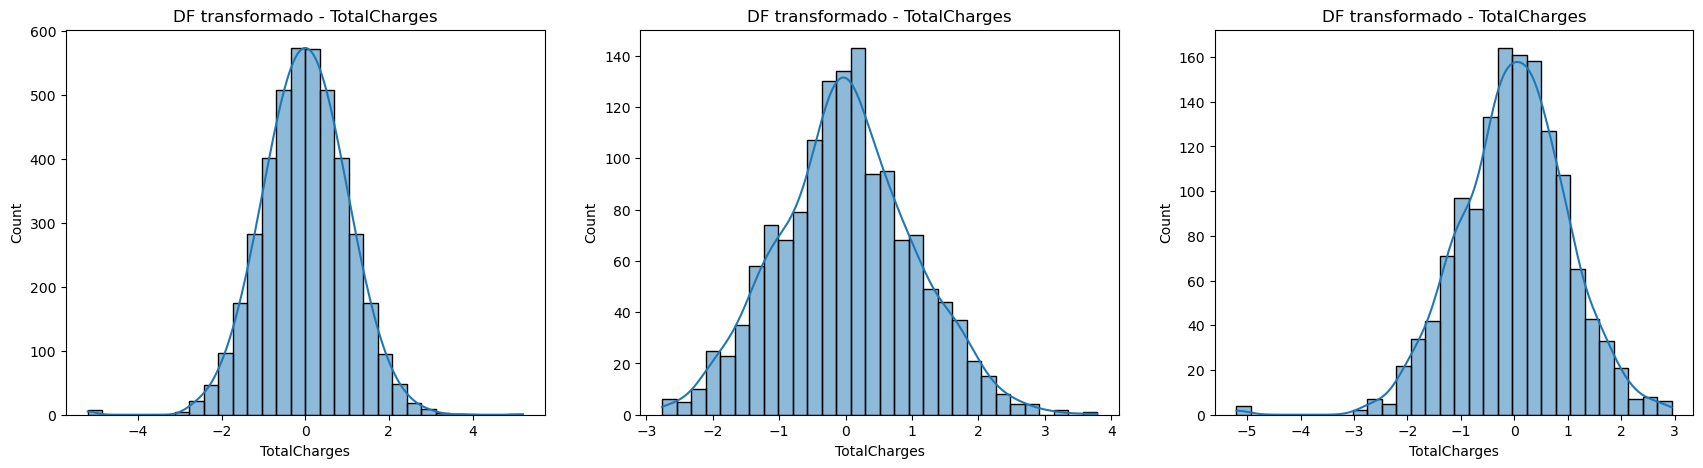

In [54]:
# ---Graficamos (Revisar el resultado de la transformación)
# 🔹 Graficamos cada DF
for col in numeric_cols:
    print(f"\n🔹 {col}: DataFrame Transformados")
    plot_distributions(
        X_train[col], X_val[col], X_test[col], f'DF transformado - {col}'
    )


In [55]:
# ---- Verificación del resultado ---
print("Se han dividido y escalado los datos en tres conjuntos usando QuantileTransformer.")
print(f"Tamaño de X_train: {X_train.shape}")
print(f"Tamaño de X_val:   {X_val.shape}")
print(f"Tamaño de X_test:  {X_test.shape}\n")

print("Primeras 5 filas de X_train (con columnas escaladas):")
print(X_train.head())

Se han dividido y escalado los datos en tres conjuntos usando QuantileTransformer.
Tamaño de X_train: (4225, 21)
Tamaño de X_val:   (1409, 21)
Tamaño de X_test:  (1409, 21)

Primeras 5 filas de X_train (con columnas escaladas):
      Type  PaperlessBilling  MonthlyCharges  TotalCharges  gender  \
2782     2                 1        0.522539      0.549948       1   
6130     2                 1       -0.162552      0.668621       0   
3459     2                 1       -0.844485     -0.336173       0   
3001     0                 0       -1.109378     -1.010276       1   
2991     0                 0        0.686750      0.570410       0   

      SeniorCitizen  Partner  Dependents  OnlineSecurity  OnlineBackup  ...  \
2782              0        1           1               1             0  ...   
6130              0        0           0               1             1  ...   
3459              0        1           1               0             0  ...   
3001              0        0       

# Modelos

## Creación de Modelos
## Entrenamiento de modelo
## Evaluación del Modelo

### Dummy Classifier

In [56]:
# ----- Creación de modelo 'DummyClassifier'
# ---- 1. Crear y entrenar el DummyClassifier ---
# Usamos la estrategia 'stratified' que respeta la distribución de clases.
dummy_model = DummyClassifier(strategy='stratified', random_state=c_random_state)
dummy_model.fit(X_train, y_train)

DummyClassifier(random_state=56106, strategy='stratified')

In [57]:
evaluate_model(dummy_model, X_val, y_val, model_name="Dummy Classifier (Set Validación)")

--- Dummy Classifier (Set Validación) ---
Accuracy: 0.6040
AUC-ROC:  0.4922
-----------------------------------------


In [58]:
evaluate_model(dummy_model, X_test, y_test, model_name="Dummy Classifier (Set Prueba)")

--- Dummy Classifier (Set Prueba) ---
Accuracy: 0.6054
AUC-ROC:  0.4940
-------------------------------------


### Logistic Regression

In [59]:
# ----- Creación del modelo 'LogisticRegression'
# ---- 1. Crear y entrenar el modelo de Regresión Logística ---
# Usamos un random_state para que los resultados sean reproducibles.
logreg_model = LogisticRegression(random_state=c_random_state)
logreg_model.fit(X_train, y_train)

LogisticRegression(random_state=56106)

In [60]:
evaluate_model(logreg_model, X_val, y_val, model_name="Regresión Logística (Set Validación)")

--- Regresión Logística (Set Validación) ---
Accuracy: 0.7999
AUC-ROC:  0.8332
--------------------------------------------


In [61]:
evaluate_model(logreg_model, X_test, y_test, model_name="Regresión Logística (Set Prueba)")

--- Regresión Logística (Set Prueba) ---
Accuracy: 0.8141
AUC-ROC:  0.8538
----------------------------------------


#### Logistic Regression (Class Weight)

In [62]:
# ----- Creación del modelo 'LogisticRegression' con 'class_weight'
# ---- 1. Crear y entrenar el modelo con class_weight='balanced' ---
logreg_balanced_model = LogisticRegression(random_state=c_random_state, class_weight='balanced')
logreg_balanced_model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', random_state=56106)

In [63]:
evaluate_model(
    logreg_balanced_model, X_val, y_val, model_name="Regresión Logística con class_weight (Set Validación)"
)

--- Regresión Logística con class_weight (Set Validación) ---
Accuracy: 0.7445
AUC-ROC:  0.8329
-------------------------------------------------------------


In [64]:
evaluate_model(
    logreg_balanced_model, X_test, y_test, model_name="Regresión Logística con class_weight (Set Prueba)"
)

--- Regresión Logística con class_weight (Set Prueba) ---
Accuracy: 0.7601
AUC-ROC:  0.8538
---------------------------------------------------------


### RandomForestClassifier

In [65]:
# ----- Modelo Random Forest Classifier
# ---- 1. Crear y entrenar el modelo RandomForestClassifier ---
# Usamos un random_state para que los resultados sean reproducibles.
rf_model = RandomForestClassifier(random_state=c_random_state)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=56106)

In [66]:
evaluate_model(rf_model, X_val, y_val, model_name="Random Forest (Set Validación)")

--- Random Forest (Set Validación) ---
Accuracy: 0.7878
AUC-ROC:  0.8146
--------------------------------------


In [67]:
evaluate_model(rf_model, X_test, y_test, model_name="Random Forest (Set Prueba)")

--- Random Forest (Set Prueba) ---
Accuracy: 0.7935
AUC-ROC:  0.8273
----------------------------------


#### RandomForestClassifier (Class Weight)

In [68]:
# ----- Creación del modelo 'RandomForestClassifier' con 'class_weight'
# --- 1. Crear y entrenar el modelo con class_weight='balanced' ---
rf_balanced_model = RandomForestClassifier(random_state=c_random_state, class_weight='balanced')
rf_balanced_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=56106)

In [69]:
evaluate_model(rf_balanced_model, X_val, y_val, model_name="Random Forest con class_weight (Set Validación)")

--- Random Forest con class_weight (Set Validación) ---
Accuracy: 0.7963
AUC-ROC:  0.8158
-------------------------------------------------------


In [70]:
evaluate_model(rf_balanced_model, X_test, y_test, model_name="Random Forest con class_weight (Set Prueba)")

--- Random Forest con class_weight (Set Prueba) ---
Accuracy: 0.7842
AUC-ROC:  0.8254
---------------------------------------------------


#### RandomForestClassifier (Hyperparameter Tunning)

In [71]:
# ----- Encontrar los mejores hyperparámetros para RandomForestClassifier
# ----Define las listas de valores que quieres probar
estimators_to_try = [600, 750, 900, 1050]
depths_to_try = [3, 5, 10, 15]

# ----Llama a la función pasándole las listas
(best_rf_model, best_rf_model_params)= find_best_rf_params(
    X_train,
    y_train,
    n_estimators_list=estimators_to_try,
    max_depth_list=depths_to_try
)

Iniciando la búsqueda de hiperparámetros para RandomForestClassifier...
Fitting 5 folds for each of 16 candidates, totalling 80 fits

Búsqueda completada.
Mejores hiperparámetros encontrados: {'max_depth': 5, 'n_estimators': 900}
Mejor puntuación AUC-ROC (en validación cruzada): 0.8487


In [72]:
evaluate_model(
    best_rf_model, X_val, y_val, model_name="Random Forest con tunning en hiperparámetros (Set Validación)"
)

--- Random Forest con tunning en hiperparámetros (Set Validación) ---
Accuracy: 0.7509
AUC-ROC:  0.8357
---------------------------------------------------------------------


In [73]:
evaluate_model(
    best_rf_model, X_test, y_test, model_name="Random Forest con tunning en hiperparámetros (Set Validación)"
)

--- Random Forest con tunning en hiperparámetros (Set Validación) ---
Accuracy: 0.7672
AUC-ROC:  0.8518
---------------------------------------------------------------------


In [74]:
print(best_rf_model.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 900, 'n_jobs': None, 'oob_score': False, 'random_state': 56106, 'verbose': 0, 'warm_start': False}


### Resample (Balanceo de Clases)

In [75]:
# ----- Oversampling clase minoritaria (clientes que ya cancelaron)
# ----Juntamos X_train y y_train temporalmente para manejar los datos fácilmente
train_data = pd.concat([X_train, y_train], axis=1)

In [76]:
# ----Verificamos la distribución de clases ANTES del sobremuestreo
print("Distribución de clases en el conjunto de entrenamiento (Antes):")
print(train_data['TargetCancel'].value_counts())

Distribución de clases en el conjunto de entrenamiento (Antes):
TargetCancel
0    3104
1    1121
Name: count, dtype: int64


In [77]:
# ----1. Separar las clases
majority_class = train_data[train_data['TargetCancel'] == 0]
minority_class = train_data[train_data['TargetCancel'] == 1]

In [78]:
# ----2. Aplicar sobremuestreo a la clase minoritaria
# 'resample' tomará muestras de la clase minoritaria con reemplazo
# hasta que iguale el número de muestras de la clase mayoritaria.
minority_upsampled = resample(minority_class,
                               replace=True,     # Permite tomar la misma muestra más de una vez
                               n_samples=len(majority_class), # Igualar al tamaño de la clase mayoritaria
                               random_state=c_random_state)

In [79]:
# ----3. Combinar la clase mayoritaria con la clase minoritaria sobremuestreada
upsampled_data = pd.concat([majority_class, minority_upsampled])

In [80]:
# ----4. Mezclar los datos (opcional pero recomendado)
upsampled_data = upsampled_data.sample(frac=1, random_state=c_random_state).reset_index(drop=True)

In [81]:
# ---Verificamos la distribución de clases DESPUÉS del sobremuestreo
print("\nDistribución de clases en el conjunto de entrenamiento (Después):")
print(upsampled_data['TargetCancel'].value_counts())


Distribución de clases en el conjunto de entrenamiento (Después):
TargetCancel
1    3104
0    3104
Name: count, dtype: int64


In [82]:
# ----5. Separar de nuevo en X_train y y_train
X_train_upsampled = upsampled_data.drop(columns='TargetCancel')
y_train_upsampled = upsampled_data['TargetCancel']

In [83]:
# ---- Mostrar Resultado de Resample
print("\nForma de los nuevos conjuntos de entrenamiento balanceados:")
print(f"X_train_upsampled: {X_train_upsampled.shape}")
print(f"y_train_upsampled: {y_train_upsampled.shape}")


Forma de los nuevos conjuntos de entrenamiento balanceados:
X_train_upsampled: (6208, 21)
y_train_upsampled: (6208,)


#### Resample-Probar modelo RandomForestClassifier (Mejores Hyperparámetros)

In [84]:
# ----- Modelo Random Forest Classifier (Datos balanceados y mejores hyperparámetros)
# ---- 1. Crear y entrenar el modelo RandomForestClassifier ---
# Usamos un random_state para que los resultados sean reproducibles.
rf_best_balanced_model = RandomForestClassifier(
    **best_rf_model_params,
    random_state=c_random_state
)
rf_best_balanced_model.fit(X_train_upsampled, y_train_upsampled)

RandomForestClassifier(max_depth=5, n_estimators=900, random_state=56106)

In [85]:
evaluate_model(
    rf_best_balanced_model, X_val, y_val,
    model_name="Random Forest con tunning en hiperparámetros y balanceo de clases (Set Validación)"
)

--- Random Forest con tunning en hiperparámetros y balanceo de clases (Set Validación) ---
Accuracy: 0.7516
AUC-ROC:  0.8350
------------------------------------------------------------------------------------------


In [86]:
evaluate_model(
    rf_best_balanced_model, X_test, y_test,
    model_name="Random Forest con tunning en hiperparámetros y balanceo de clases (Set Prueba)"
)

--- Random Forest con tunning en hiperparámetros y balanceo de clases (Set Prueba) ---
Accuracy: 0.7658
AUC-ROC:  0.8511
--------------------------------------------------------------------------------------


#### Resample-Probar mejor modelo LogisticRegression

In [87]:
# ----- Creación del modelo 'LogisticRegression'
# ---- 1. Crear y entrenar el modelo de Regresión Logística ---
# Usamos un random_state para que los resultados sean reproducibles.
logreg_balanced_model = LogisticRegression(random_state=c_random_state)
logreg_balanced_model.fit(X_train, y_train)

LogisticRegression(random_state=56106)

In [88]:
evaluate_model(
    logreg_balanced_model, X_val, y_val, model_name="Regresión Logística con  balanceo de clases (Set Validación)"
)

--- Regresión Logística con  balanceo de clases (Set Validación) ---
Accuracy: 0.7999
AUC-ROC:  0.8332
--------------------------------------------------------------------


In [89]:
evaluate_model(
    logreg_balanced_model, X_test, y_test, model_name="Regresión Logística con  balanceo de clases (Set Prueba)"
)

--- Regresión Logística con  balanceo de clases (Set Prueba) ---
Accuracy: 0.8141
AUC-ROC:  0.8538
----------------------------------------------------------------


### LGBMClassifier (Con Balanceo de Clases)

In [90]:
# ----- LGBMClassifier (Con Balanceo de Clases)
# ---- 1. Crear y entrenar el modelo LGBMClassifier ---
# Usamos los datos sobremuestreados que nos dieron el mejor resultado anterior.
# Se usa un random_state para la reproducibilidad.
lgbm_model = lgb.LGBMClassifier(random_state=c_random_state)
lgbm_model.fit(X_train_upsampled, y_train_upsampled)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3104, number of negative: 3104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000352 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 620
[LightGBM] [Info] Number of data points in the train set: 6208, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


LGBMClassifier(random_state=56106)

In [91]:
evaluate_model(
    lgbm_model, X_val, y_val, model_name="LGBMClassifier con  balanceo de clases (Set Validación)"
)

--- LGBMClassifier con  balanceo de clases (Set Validación) ---
Accuracy: 0.7615
AUC-ROC:  0.8231
---------------------------------------------------------------


In [92]:
evaluate_model(
    lgbm_model, X_test, y_test, model_name="LGBMClassifier con  balanceo de clases (Set Prueba)"
)

--- LGBMClassifier con  balanceo de clases (Set Prueba) ---
Accuracy: 0.7679
AUC-ROC:  0.8370
-----------------------------------------------------------


#### LGBMClassifier (Con Balanceo de Clases) e Hiperparámetros

In [93]:
# ----- LGBMClassifier (Con Balanceo de Clases) e Hiperparámetros
# ---- Definir rango de hiperparámetros a probar
lgbm_param_grid = {
    'n_estimators': [850, 900, 950, 1000],
    'learning_rate': [0.05, 0.1, 0.25],
    'num_leaves': [60, 65, 70],
    'max_depth': [20, 25, 30]
}

In [94]:
# ----Llama a la función con los datos sobremuestreados y los hiperparámetros a probar
(best_lgbm_model, best_lgbm_model_params) = find_best_lgbm_params(
    X_train_upsampled,
    y_train_upsampled,
    lgbm_param_grid
)

Iniciando la búsqueda de hiperparámetros para LGBMClassifier...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3104, number of negative: 3104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000336 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 620
[LightGBM] [Info] Number of data points in the train set: 6208, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

Búsqueda completada.
Mejores hiperparámetros encontrados: {'learning_rate': 0.1, 'max_depth': 30, 'n_estimators': 850, 'num_leaves': 70}
Mejor puntuación AUC-ROC (en validación cruzada): 0.9652


In [95]:
evaluate_model(
    best_lgbm_model, X_val, y_val,
    model_name="LGBMClassifier con tunning en hiperparámetros y balanceo de clases (Set Validación)"
)

--- LGBMClassifier con tunning en hiperparámetros y balanceo de clases (Set Validación) ---
Accuracy: 0.7828
AUC-ROC:  0.7956
-------------------------------------------------------------------------------------------


In [96]:
evaluate_model(
    best_lgbm_model, X_test, y_test,
    model_name="LGBMClassifier con tunning en hiperparámetros y balanceo de clases (Set Prueba)"
)

--- LGBMClassifier con tunning en hiperparámetros y balanceo de clases (Set Prueba) ---
Accuracy: 0.7736
AUC-ROC:  0.8051
---------------------------------------------------------------------------------------


In [97]:
print(best_lgbm_model.get_params())

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 30, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 850, 'n_jobs': None, 'num_leaves': 70, 'objective': None, 'random_state': 56106, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


## Resumen de Modelos

Modelo	Configuración	AUC-ROC (Validación)	AUC-ROC (Prueba)	¿Cumple Objetivo? (≥ 0.85)

📊 Dummy	Estratificado (Línea Base)	0.4922	0.494	❌ No

⚖️ Logistic Regression	Básico	0.8332	0.8538	✅ Sí
	Con class_weight	0.8329	0.8537	✅ Sí
	Con Sobremuestreo	0.8332	0.8538	✅ Sí
				
🌳 Random Forest	Básico	0.8146	0.8273	❌ No
	Con class_weight	0.8163	0.8217	❌ No
	Optimizado (max_depth=5, n_est=900)	0.8357	0.8517	✅ Sí
	Optimizado + Sobremuestreo	0.835	0.8511	✅ Sí
				
🚀 LightGBM	Básico + Sobremuestreo	0.8231	0.837	❌ No
	Optimizado + Sobremuestreo	0.7956	0.8051	❌ No

**Conclusiones**

   * El Mejor Modelo: La Regresión Logística (tanto en su versión básica como con sobremuestreo), alcanza un AUC-ROC final de 0.8538 en el conjunto de prueba. Esto nos demuestra que un modelo más simple, pero con un buen preprocesamiento de datos, puede ser el más efectivo.

# Conclusiones y Preparación de Informe

**¿Qué pasos del plan se realizaron y qué pasos se omitieron (explica por qué)?**

   * Los pasos detallados en el plan inicial se realizaron, al contrario, se tuvo que agregar pasos conforme se avanzaba en el plan inicial, por ejemplo:
      * Se identificó que la información de nuestro grupo de datos se conformaba de variables categóricas y numéricas.
      * Se tuvo que realizar OHE para las categóricas al revisar que la mayoría eran variables de 2 opciones.
         * En este punto también se observó la necesidad de eliminar la multicolinelidad.
      * Se identificó la variable categórica 'Type' que el valor si presentaba un orden de mayor importancia según el cliente.
      * Para las variables numéricas se aplicó un escalador, se intentó primero 'StandardScaler', pero con la gráfica de distribución de los datos se observaron valores extremos, por lo que al final se optó por 'QuantileScaler' y pasarlo a una distribución normal.

   * En los modelos se agregó un modelo adicional 'LGBMClassifier'. No superó al modelo más simple 'LogisticRegression' y nos ayudó a confirmar que en ocasiones el tratamiento de los datos tiene mayor importancia que el modelo.

**¿Qué dificultades encontraste y cómo lograste resolverlas?**

   * La diferente naturaleza de nuestras características en el set de datos:
      * Se resolvió tratando las columnas por grupo de similitud y acción que se debería aplicar. Al final de cada paso se revisaba de nuevo el estado del DataFrame lo que permitía definir el siguiente paso. Hacer una revisión paso a paso en el tratamiento de datos es muy útil para reforzar la construcción de los datos y confirmar su importancia en el modelo a construir.

**¿Cuáles fueron algunos de los pasos clave para resolver la tarea?**

   * El procesamiento de los datos. Al entrenar los primeros modelos se dió la sorpresa que el algoritmo más sencillo fué el que obtuvo mejor puntaje.
      * El éxito de la Regresión Logística resalta la importancia de todo el trabajo que se realizó en la preparación de datos: la creación de la variable Tenure, la codificación inteligente de variables y el escalamiento con QuantileTransformer fueron fundamentales para que un modelo lineal pudiera rendir tan bien.
   * A pesar de no obtener la puntuación más alta con un modelo más completo como 'RandomForestClassifier' se observó la importancia de encontrar los mejores parámetros para cada modelo. Con la optimización de hiperparámetros se puede lograr una mejora que puede ser significativa para las tareas a resolver.
   * Tanto el balanceo con class_weight como el sobremuestreo no ofrecieron mejoras sustanciales sobre el AUC-ROC, probablemente porque el escalador ya mitigaba el efecto del desbalance.

**¿Cuál es tu modelo final y qué nivel de calidad tiene?**

   * Aquí está de nuevo el resumen de los modelos desarrollados:

Modelo	Configuración	AUC-ROC (Validación)	AUC-ROC (Prueba)	¿Cumple Objetivo? (≥ 0.85)

📊 Dummy	Estratificado (Línea Base)	0.4922	0.494	❌ No

⚖️ Logistic Regression	Básico	0.8332	0.8538	✅ Sí
	Con class_weight	0.8329	0.8537	✅ Sí
	Con Sobremuestreo	0.8332	0.8538	✅ Sí
				
🌳 Random Forest	Básico	0.8146	0.8273	❌ No
	Con class_weight	0.8163	0.8217	❌ No
	Optimizado (max_depth=5, n_est=900)	0.8357	0.8517	✅ Sí
	Optimizado + Sobremuestreo	0.835	0.8511	✅ Sí
				
🚀 LightGBM	Básico + Sobremuestreo	0.8231	0.837	❌ No
	Optimizado + Sobremuestreo	0.7956	0.8051	❌ No


   * El modelo a seleccionar con el mejor puntaje para nuestras métricas es '**LogisticRegression**' con un puntaje de '**0.8538**' para nuestra métrica 'AUC-ROC'
      * Esta métrica es muy útil para este tipo de tareas. Un puntaje alto significa que nuestro modelo es bueno para distinguir la clase minoritaria de nuestros datos. Y este es el objetivo principal, saber que cliente puede estar próximo a solicitar una cancelación y poder tomar acciones antes para evitar esto.
